# Homework 1: Una semplice tecnica di codifica d'immagini basata sulla DCT

### 1. Caricare un'immagine a colori RGB  in formato BMP e/o JPG e/o PGM (uno dei tre formati è sufficiente)

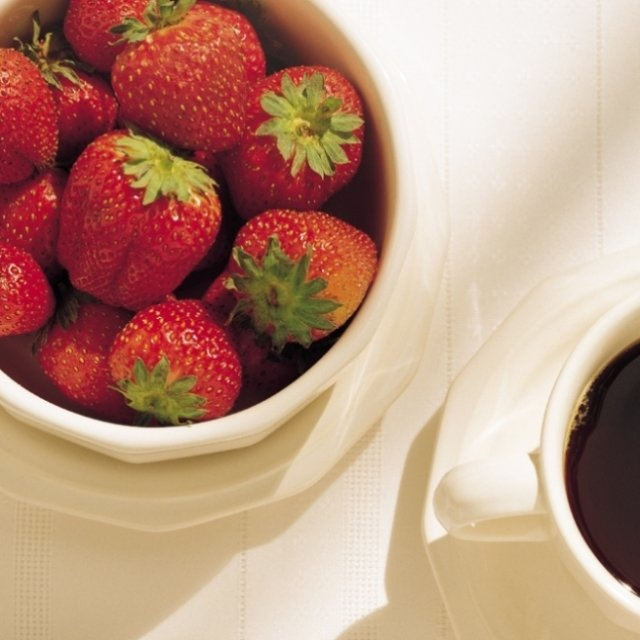

In [306]:
from PIL import Image

# apriamo immagine originale
image = Image.open("img.jpg")

display(image)

### 2. Effettuare il cambio di spazio dei colori da RGB a YCbCr

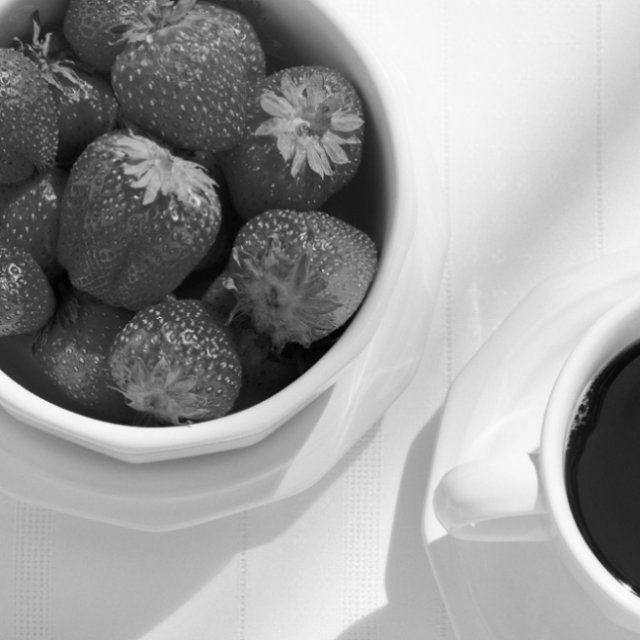

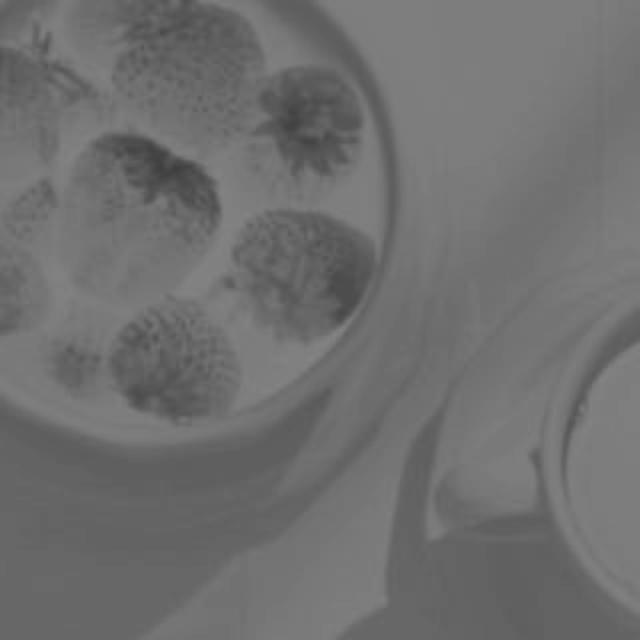

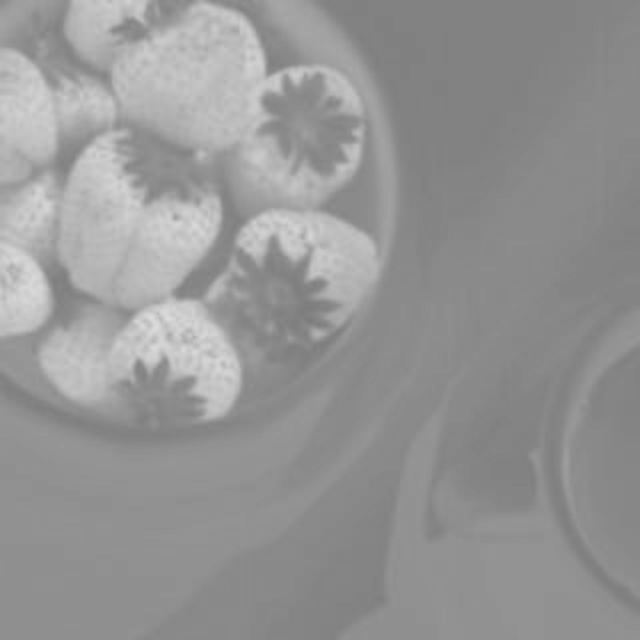

In [307]:
import numpy as np

# convertiamo immagine da spazio RGB a spazio YCbCr
image_ycbcr = image.convert('YCbCr')

# associamo indice a componenti YCbCr
Y, Cb, Cr = 0, 1, 2
C = [Y, Cb, Cr]

# oggetto PIL.Image diventa array numpy con componenti YCbCr espressi per righe e colonne (range 0-255)
np_ycbcr = list(image_ycbcr.getdata())
np_ycbcr = np.reshape(np_ycbcr, (image.size[1], image.size[0], 3))
np_ycbcr = np.uint8(np_ycbcr)

# separiamo componenti e le mostriamo in scala di grigi
C_data = []
for c in C:
    C_data.append(np_ycbcr[:,:,c])
    display(Image.fromarray(C_data[c], "L"))

### 3 Per ognuna delle componenti Y, Cb e Cr, dato un numero R tra 1 e 100:

In [308]:
R = 97

### 3.1 Effettua la DCT bidimensionale con blocchi di dimensione parametrizzabile N della componente

Text(0.5, 1.0, 'DCT')

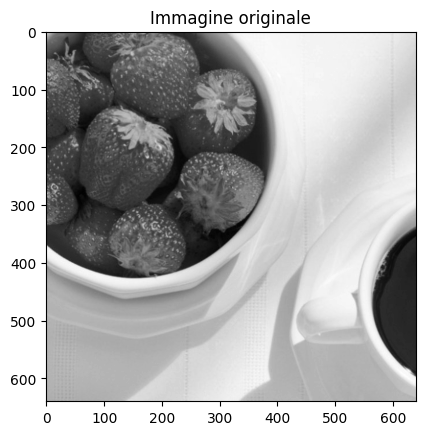

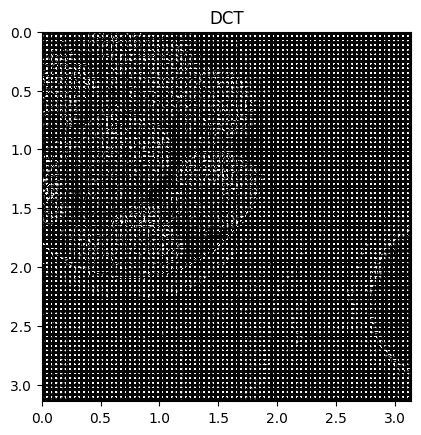

In [309]:
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt

# definiamo dimensione blocchi
N = 8

# applichiamo DCT a blocchi
C_dct = []
for c in C:
    c_d = C_data[c]
    c_shape = c_d.shape
    dct = np.zeros(c_shape)

    for i in np.r_[:c_shape[0]:N]:
        for j in np.r_[:c_shape[1]:N]:
            dct[i:(i+N), j:(j+N)] = fftpack.dctn(c_d[i:(i+N), j:(j+N)], axes=[0,1], norm="ortho")

    C_dct.append(dct)

# mostriamo solo componente Y
plt.figure()
plt.imshow(C_data[Y],cmap='gray')
plt.title("Immagine originale")

plt.figure()
plt.imshow(C_dct[Y],cmap='gray',vmax= np.max(dct)*0.01,vmin = 0, extent=[0,np.pi,np.pi,0])
plt.title("DCT")

#tmpt = Image.fromarray(dct)
#tmpt.convert("L").save("dct.jpg")

### 3.2 Mette a zero una frazione pari a R% dei coefficienti DCT dell'intera componente, **e più precisamente quelli più piccoli di un'opportuna soglia**

Keeping only 4.446289% of the DCT coefficients


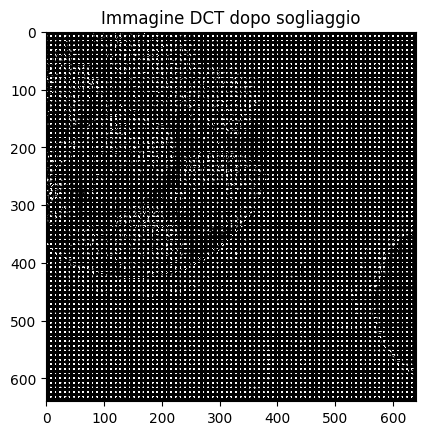

In [310]:
# Threshold
C_dct_thresh = []
for c in C:
    dct = C_dct[c]
    p = np.percentile(dct, R, method='lower')
    dct = dct * (abs(dct) > p)
    C_dct_thresh.append(dct)

plt.figure()
plt.imshow(C_dct_thresh[0],cmap='gray',vmax = np.max(C_dct_thresh[0])*0.01,vmin = 0)
plt.title( "Immagine DCT dopo sogliaggio")

Y_shape = C_dct_thresh[0].shape
percent_nonzeros = np.sum( C_dct_thresh[0] != 0.0 ) / (Y_shape[0]*Y_shape[1]*1.0)

print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))

### 3.3 Effettua la DCT inversa sui blocchi dopo sogliaggio, ottenendo la versione "compressa" della componente

Text(0.5, 1.0, 'Comparison between original and DCT compressed images')

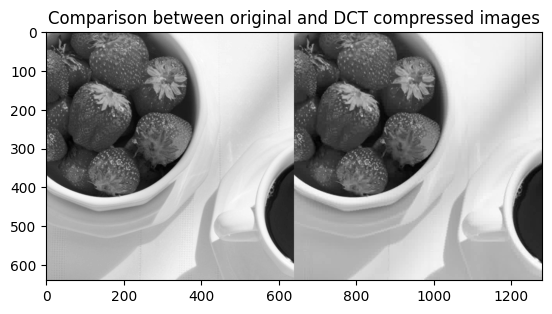

In [311]:
C_idct = []

for c in C:
    c_d_t = C_dct_thresh[c]
    shape = c_d_t.shape
    idct = np.zeros(shape)

    for i in np.r_[:shape[0]:N]:
        for j in np.r_[:shape[1]:N]:
            idct[i:(i+N), j:(j+N)] = fftpack.idctn(c_d_t[i:(i+N), j:(j+N)], axes=[0,1], norm="ortho")

    C_idct.append(np.clip(idct, 0, 255))

plt.figure()
plt.imshow( np.hstack( (C_data[Y], C_idct[Y]) ) ,cmap='gray')
plt.title("Comparison between original and DCT compressed images" )

In [312]:
bands = tuple(Image.fromarray(np.uint8(i)) for i in C_idct)
print(type(bands[Y]))
inversed = Image.merge('YCbCr', bands)
inversed.show()

<class 'PIL.Image.Image'>


### 3.4 Calcola l'MSE tra la componente originale e la componente "compressa"

In [313]:
C_mse = []

for c in C:
    C_mse.append((np.square(C_data[c] - C_idct[c])).mean())

print(C_mse)

[13.440438867569231, 0.28033331605674183, 0.3536969379811309]


### 4 Calcola l'MSE pesato: MSE_P = 3/4 MSE_Y + 1/8 MSE_Cb + 1/8 MSE_Cr

In [314]:
coeff = [3/4, 1/8, 1/8]
mse_p = sum((C_mse[i] * coeff[i]) for i in range(3))
print(mse_p)

10.159582932431658


### 5 Calcola il PSNR pesato come 10log_10 (255^2/MSE_P)

In [315]:
psnr = 10 * np.log10(np.square(255) / mse_p)
print(psnr)

38.06204481055965


### 6 Ripete i passi da 3 a 5 per diversi valori di R: da 10 a 100 a passi di 10

In [ ]:
n = [8, 16, 64]
n_c = ['r', 'b', 'g']
r = range(30, 105, 5)
values = [("N="+str(N)) for N in n]

for I in range(3):
    N = n[I]
    PSNR = []
    C_dct = []
    for c in C:
        c_d = C_data[c]
        c_shape = c_d.shape
        dct = np.zeros(c_shape)

        for i in np.r_[:c_shape[0]:N]:
            for j in np.r_[:c_shape[1]:N]:
                dct[i:(i+N), j:(j+N)] = fftpack.dctn(c_d[i:(i+N), j:(j+N)], axes=[0,1], norm="ortho")

        C_dct.append(dct)

    for R in r:
            
        # Threshold
        C_dct_thresh = []
        for c in C:
            dct = C_dct[c]
            p = np.percentile(dct, R)
            C_dct_thresh.append(dct * (abs(dct) > p))

        C_idct = []
        for c in C:
            c_d_t = C_dct_thresh[c]
            shape = c_d_t.shape
            idct = np.zeros(shape)

            for i in np.r_[:shape[0]:N]:
                for j in np.r_[:shape[1]:N]:
                    idct[i:(i+N), j:(j+N)] = fftpack.idctn(c_d_t[i:(i+N), j:(j+N)], axes=[0,1], norm="ortho")

            #C_idct.append(np.around(idct))
            C_idct.append(idct)

        C_mse = []
        for c in C:
            C_mse.append((np.square(C_data[c] - C_idct[c])).mean())
        coeff = [3/4, 1/8, 1/8]
        mse_p = sum((C_mse[i] * coeff[i]) for i in range(3))
        PSNR.append(10 * np.log10(np.square(255) / mse_p))

    plt.plot(r, PSNR, n_c[I])

plt.legend(labels=values)
plt.show()